In [5]:
from collections import defaultdict
import matplotlib.pyplot as plt
import scipy
import snap

def AddNode(Graph, node_to_id, node_name, new_node_id):
    # This function adds a new node to the graph and
    # updates the protein name -> node id mapping.
    Graph.AddNode(new_node_id)
    node_to_id[node_name] = new_node_id
    return new_node_id + 1

def OpenCorrelationInfoFile(path):
    # Opens the edge list file at 'path',
    # construct the graph and the node name to node id mapping,
    # and return both.
    with open(path, 'r') as f:
        # Skip the first line
        next(f)
        # Read all lines, constructing the graph as we go.
        new_node_id = 1
        Graph = snap.TNEANet.New()
        node_to_id = {}
        for line in f:
            values = line.split()
            start_node_id = -1
            end_node_id = -1
            if values[0] not in node_to_id:
                AddNode(Graph, node_to_id, values[0], new_node_id)
                start_node_id = new_node_id
                new_node_id += 1
            else:
                start_node_id = node_to_id[values[0]]
            if values[1] not in node_to_id:
                AddNode(Graph, node_to_id, values[1], new_node_id)
                end_node_id = new_node_id
                new_node_id += 1
            else:
                end_node_id = node_to_id[values[1]]
            
            # Add the edge
            Graph.AddEdge(start_node_id, end_node_id)

        return Graph, node_to_id

def ComputeInDegreeDistribution(Graph):
    # Compute the in degree distribution and return X, Y values for plotting
    d = defaultdict(lambda: 0)
    for node in Graph.Nodes():
        d[node.GetInDeg()] += 1
    
    d = {k: float(d[k]) / Graph.GetNodes() for k in d.keys()}
    X = d.keys()
    Y = d.values()
    return X, Y

def ComputeOutDegreeDistribution(Graph):
    # Compute the in degree distribution and return X, Y values for plotting
    d = defaultdict(lambda: 0)
    for node in Graph.Nodes():
        d[node.GetOutDeg()] += 1
    
    d = {k: float(d[k]) / Graph.GetNodes() for k in d.keys()}
    X = d.keys()
    Y = d.values()
    return X, Y

def ComputeStatistics(Graph):
    # Compute some simple statistics. 
    # Node counts, edge counts, clustering coeffs, degree distributions.
    print 'Number of nodes = %d' % Graph.GetNodes()
    print 'Number of edges = %d' % Graph.GetEdges()
    print 'Average clustering coefficient = %f' % snap.GetClustCf(Graph)
    # Plot the in-deg and out-deg distributions, and fit a power law distribution to them.
    X_in, Y_in = ComputeInDegreeDistribution(Graph)
    X_out, Y_out = ComputeOutDegreeDistribution(Graph)
    plt.loglog(X_in, Y_in, 'o', color = 'r', label = 'In Degree')
    plt.loglog(X_out, Y_out, '+', color = 'b', label = 'Out Degree')
    plt.show()
    # TODO: We should also compute some other statistics, such as largest CC, largest weakly connected CC,
    # local modularity, fraction of known disease proteins, etc.
    

In [3]:
Graph, node_to_id = OpenCorrelationInfoFile('new_edges-CORRELATIONINFO.txt')


Number of nodes = 31693
Number of edges = 2264289
Average clustering coefficient = 0.033093


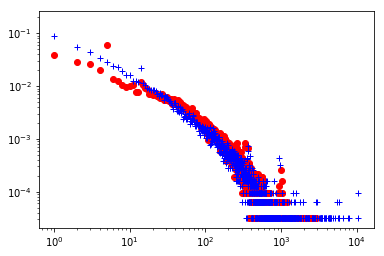

In [4]:
ComputeStatistics(Graph)

In [16]:
from math import log, exp
from scipy.special import gammaln

# In this section I'll start implementing the DIAMOND algorithm. We start with the definition to the link
# significance as defined by the DIAMOND paper. The link significance is defined as the probability that,
# if we randomly selected s_0 seed proteins as disease proteins, what is the probability that a node with
# k out edges point to exactly k_s of those seed proteins? This is a hypergeometric distribution, where
# the total event space of the node with k out edges is of size N choose k, and the situations in which exactly
# k_s of those k edges point to the s_0 seed proteins is (s_0 choose k_s) * ((N - s_0) choose (k - k_s)).
# Note that this is not exactly drawing black/white balls out of bins, so we cannot directly use scipy.hypergeom.
# This function needs to be implemented with some care, namely:
#   * We are dealing with large numbers, so directly applying N choose k is bad. Instead we should operate in
#     log space.
#   * k! can be expressed as the Gamma function Gamma(k + 1)
#   * Thus, N choose k = Gamma(N + 1) / (Gamma(k + 1) * Gamma(N - k + 1))
#   * In log space, log( N choose k ) = LogGamma(N + 1) - (LogGamma(k + 1) + LogGamma(N - k + 1))
#   * scipy has a gammaln function for LogGamma.

def LogChoose(n, k):
    return gammaln(n + 1) - (gammaln(k + 1) + gammaln(n - k + 1))

# The probability mass function is defined as:
#   pmf(k_s, k, N, s_0) = (s_0 choose k_s) * ((N - s_0) choose (k - k_s)) / (N choose k)
# In log space:
#   ln pmf = ln(s_0 choose k_s) + ln((N - s_0) choose (k - k_s)) - ln(N choose k)
#          = LogChoose(s_0, k_s) + LogChoose(N - s_0, k - k_s) - LogChoose(N, k)
# We can exponentiate that to get the answer.
def DiseaseProteinHyperGeomPmf(k, k_s, N, s_0):
    log_pmf = LogChoose(s_0, k_s) + LogChoose(N - s_0, k - k_s) - LogChoose(N, k)
    return exp(log_pmf)

# Finally, we can compute the link signficance as the p-value of the null hypothesis that the linking
# is random. This is just the complementary CDF of the hypergeometric distribution:
#   p-value = P( X >= k_s ) = \sum_{k_i = k_s}^{k} pmf(k_i, k, N, s_0)

def CCDF_HyperGeom(k, k_s, N, s_0):
    ccdf = 0.0
    for k_i in range(k_s, k + 1):
        ccdf += DiseaseProteinHyperGeomPmf(k, k_i, N, s_0)
    return ccdf

In [19]:
print CCDF_HyperGeom(10, 5, 100, 20)

0.025464546427
